In [16]:
import pandas as pd

df = pd.read_csv("/Users/danielmartinezvillegas/Desktop/audio_magenta/info.csv")
df

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test
...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train


# Helper

In [17]:
import numpy as np

def separate_hv_list(hv_list):
    """
    Convert a hit-velocity list to a 3-band representation (low, mid, high)
    
    Parameters:
    hv_list (list): List of note/velocity pairs organized by step
    
    Returns:
    numpy.ndarray: 3x16 matrix with rows representing low, mid, high frequency bands
    """
    # Create a 3×16 matrix (assuming hv_list is 16 steps)
    matrix = np.zeros((3, len(hv_list)))
    
    # List of MIDI instruments by category
    lows = [35, 36, 41, 45, 47, 64, 66]
    mids = [37, 38, 39, 40, 43, 48, 50, 61, 62, 65, 68, 77]
    highs = [22, 26, 42, 44, 46, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 67, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81]
    
    # Process each step in the bar
    for i, step in enumerate(hv_list):
        low_energy = 0
        mid_energy = 0
        high_energy = 0
        
        # Process each onset (drum hit) in the step
        for onset in step:
            note = onset[0]  # MIDI note number
            vel = onset[1]   # Velocity (intensity)
            
            # Add energy to appropriate frequency band
            if note in lows:
                low_energy += vel
            elif note in mids:
                mid_energy += vel
            else:  # Assume it's high
                high_energy += vel
        
        # Store values in matrix
        matrix[0, i] = low_energy
        matrix[1, i] = mid_energy
        matrix[2, i] = high_energy
    
    # Normalize each row to have max value of 1
    for j in range(3):
        if np.max(matrix[j]) > 0:  # Avoid division by zero
            matrix[j] = matrix[j] / np.max(matrix[j])
    
    return matrix

In [18]:
#@title Helper functions
import mido
import math
import numpy as np

# general MIDI drum key map implemented as a dictionary.
# we use this to: (1) filter out possible non GMDKM notes (2) avoid duplicate instrument redundance (i.e. there are two kick drums, two snares, several low toms, etc) (3) aid remapping the MIDI drum file using different kits (i.e. only kick, snare and hihat; an 8 piece kit; 16 piece or all instruments ).

GM_dict = {
    # key is midi note number
    # values are:
    # [0] name (as string)
    # [1] name category low mid or high (as string)
    # [2] substiture midi number for simplified MIDI (all instruments)
    # [3] name of instrument for 8 note conversion (as string)
    # [4] number of instrument for 8 note conversion
    # [5] substiture midi number for conversion to 8 note
    # [6] substiture midi number for conversion to 16 note
    # [7] substiture midi number for conversion to 3 note
    # if we are going to remap just use GM_dict[msg.note][X]
    22: ["Closed Hi-Hat edge", "high", 42, "CH", 3, 42, 42, 42],
    26: ["Open Hi-Hat edge", "high", 46, "OH", 4, 46, 46, 42],
    35: ["Acoustic Bass Drum", "low", 36, "K", 1, 36, 36, 36],
    36: ["Bass Drum 1", "low", 36, "K", 1, 36, 36, 36],
    37: ["Side Stick", "mid", 37, "RS", 6, 37, 37, 38],
    38: ["Acoustic Snare", "mid", 38, "SN", 2, 38, 38, 38],
    39: ["Hand Clap", "mid", 39, "CP", 5, 39, 39, 38],
    40: ["Electric Snare", "mid", 38, "SN", 2, 38, 38, 38],
    41: ["Low Floor Tom", "low", 45, "LT", 7, 45, 45, 36],
    42: ["Closed Hi Hat", "high", 42, "CH", 3, 42, 42, 42],
    43: ["High Floor Tom", "mid", 45, "HT", 8, 45, 45, 38],
    44: ["Pedal Hi-Hat", "high", 46, "OH", 4, 46, 46, 42],
    45: ["Low Tom", "low", 45, "LT", 7, 45, 45, 36],
    46: ["Open Hi-Hat", "high", 46, "OH", 4, 46, 46, 42],
    47: ["Low-Mid Tom", "low", 47, "MT", 7, 45, 47, 36],
    48: ["Hi-Mid Tom", "mid", 47, "MT", 7, 50, 50, 38],
    49: ["Crash Cymbal 1", "high", 49, "CC", 4, 46, 42, 42],
    50: ["High Tom", "mid", 50, "HT", 8, 50, 50, 38],
    51: ["Ride Cymbal 1", "high", 51, "RC", -1, 42, 51, 42],
    52: ["Chinese Cymbal", "high", 52, "", -1, 46, 51, 42],
    53: ["Ride Bell", "high", 53, "", -1, 42, 51, 42],
    54: ["Tambourine", "high", 54, "", -1, 42, 69, 42],
    55: ["Splash Cymbal", "high", 55, "OH", 4, 46, 42, 42],
    56: ["Cowbell", "high", 56, "CB", -1, 37, 56, 42],
    57: ["Crash Cymbal 2", "high", 57, "CC", 4, 46, 42, 42],
    58: ["Vibraslap", "mid", 58, "VS", 6, 37, 37, 42],
    59: ["Ride Cymbal 2", "high", 59, "RC", 3, 42, 51, 42],
    60: ["Hi Bongo", "high", 60, "LB", 8, 45, 63, 42],
    61: ["Low Bongo", "mid", 61, "HB", 7, 45, 64, 38],
    62: ["Mute Hi Conga", "mid", 62, "MC", 8, 50, 62, 38],
    63: ["Open Hi Conga", "high", 63, "HC", 8, 50, 63, 42],
    64: ["Low Conga", "low", 64, "LC", 7, 45, 64, 36],
    65: ["High Timbale", "mid", 65, "", 8, 45, 63, 38],
    66: ["Low Timbale", "low", 66, "", 7, 45, 64, 36],
    67: ["High Agogo", "high", 67, "", -1, 37, 56, 42],
    68: ["Low Agogo", "mid", 68, "", -1, 37, 56, 38],
    69: ["Cabasa", "high", 69, "MA", -1, 42, 69, 42],
    70: ["Maracas", "high", 69, "MA", -1, 42, 69, 42],
    71: ["Short Whistle", "high", 71, "", -1, 37, 56, 42],
    72: ["Long Whistle", "high", 72, "", -1, 37, 56, 42],
    73: ["Short Guiro", "high", 73, "", -1, 42, 42, 42],
    74: ["Long Guiro", "high", 74, "", -1, 46, 46, 42],
    75: ["Claves", "high", 75, "", -1, 37, 75, 42],
    76: ["Hi Wood Block", "high", 76, "", 8, 50, 63, 42],
    77: ["Low Wood Block", "mid", 77, "", 7, 45, 64, 38],
    78: ["Mute Cuica", "high", 78, "", -1, 50, 62, 42],
    79: ["Open Cuica", "high", 79, "", -1, 45, 63, 42],
    80: ["Mute Triangle", "high", 80, "", -1, 37, 75, 42],
    81: ["Open Triangle", "high", 81, "", -1, 37, 75, 42],
}




def midifile2hv_list(file_name, mapping):
    '''
    pattern name must include .mid
    get a MIDI file and convert it to an hv_list (a list of note numbers and velocity)
    use the "mapping" variable to define the type of instrument mapping
    that will be used in the hv_list "all", "16", "8", "3"
    '''
    pattern=[]
    mid=mido.MidiFile(file_name) #create a mido file instance
    sixteenth= mid.ticks_per_beat/4 #find the length of a sixteenth note
    #print ("sixteenth", sixteenth)

    # time: inside a track, it is delta time in ticks (integrer).
    # A delta time is how long to wait before the next message.
    acc=0 #use this to keep track of time

    # depending on the instruments variable select a notemapping
    if mapping=="all":
        column=2
    elif mapping=="16":
        column=6
    elif mapping=="8":
        column=5
    elif mapping=="3":
        column=7
    else: column = 2 # if no mapping is selected use "allinstrument" mapping

    for i, track in enumerate(mid.tracks):
        for msg in track: #process all messages
            acc += msg.time # accumulate time of any message type
            if msg.type == "note_on":
                midinote = GM_dict[msg.note][column] #remap msg.note by demand
                rounded_step = int((acc/sixteenth)+0.45)
                midivelocity = float(msg.velocity)/127 # normalize upfront
                pattern.append((int(acc/sixteenth), midinote, midivelocity)) # step, note, velocity
        if len(pattern)>0: #just proceed if analyzed pattern has at least one onset
            #round the pattern to the next multiple of 16
            pattern_len_in_steps = 16 * ((rounded_step//16)+((rounded_step%16)+16)//16)
            #create an empty list of lists the size of the pattern
            output_pattern=[[]]*pattern_len_in_steps
            # group the instruments and their velocity that played at a specific step
            i = 0
            for step in range(pattern_len_in_steps):
                step_content = [(x[1],x[2]) for x in pattern if x[0]==step]
                # make sure no notes are repeated and events are sorted
                # present_notes = [x[0] for x in step_content]
                # unique_notes_in_step = list(set(present_notes))
                # remove repeated notes at the same step
                result = {}
                for tup in step_content:
                    note, vel = tup
                    if note not in result or vel > result[note][1]:
                        result[note] = tup

                step_content = list(result.values()) # dictionary to tuple list
                step_content.sort() #sort by note ascending
                output_pattern[step] = step_content

    ##################################
    # split the pattern every 16 steps
    ##################################
    hv_lists_split=[]
    for x in range(len(output_pattern)//16):
        patt_fragment = output_pattern[x*16:(x*16)+16]
        patt_density = sum([1 for x in patt_fragment if x!=[]])
        #############################################################
        # filter out patterns that have less than 4 events with notes
        #############################################################
        # NOTE: more conditions could be added (i.e. kick on step 0, etc)
        #############################################################
        if patt_density > 4:
            hv_lists_split.append(patt_fragment)
  # output is a 16-step pattern
    return hv_lists_split

def flatten_hv_list(hv_list):
# input an hv list and output a flattened representation as a v_list

  # list of MIDI instruments and categories
  lows =  [35, 36, 41, 45, 47, 64, 66]
  mids =  [37, 38, 39, 40, 43, 48, 50, 61, 62, 65, 68, 77]
  his = [22, 26, 42, 44, 46, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 67, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81]

  flat = np.zeros([len(hv_list),1])

  # multiply velocities and categories
  for i,step in enumerate(hv_list):
    step_weight = 0
    for onset in step:
      if onset[0] in lows:
        step_weight += onset[1]*3
      elif onset[0] in mids:
        step_weight += onset[1]*2
      else:
        step_weight += onset[1]*1
      flat[i] = step_weight

  flat = flat/max(flat)

  return flat

# Dataloader

In [19]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import librosa
import librosa.display

class GrooveDataset(Dataset):
    """Audio dataset for midi groove with 3-band frequency representation"""
    def __init__(self, root_dir):
        df = pd.read_csv(os.path.join(root_dir, "info.csv"))
        # filter fills from the dataset
        df = df[df["beat_type"] == "beat"]
        initial_len = len(df)
        df = df.dropna(subset=["audio_filename", "midi_filename"])
        filtered_len = len(df)

        if initial_len > filtered_len:
            print(f"Filtered out {initial_len - filtered_len} examples with NaN filenames")
        self.root_dir = root_dir
        self.data = df.to_dict(orient="records")

    def __getitem__(self, index):
        data_dict = self.data[index]

        x, fs = torchaudio.load(os.path.join(self.root_dir, data_dict["audio_filename"]))
        bpm = data_dict["bpm"]
        hv_list = midifile2hv_list(os.path.join(self.root_dir, data_dict["midi_filename"]), "all")
        midi_reps = []
        for e in hv_list:
            midi_reps.append(separate_hv_list(e))  # Using the new function instead of flatten_hv_list

        return x, fs, midi_reps, bpm, data_dict["style"]

    def __len__(self):
        return len(self.data)

def plot_groove(sample, tempo, file, fs,duration):
  # set figure
  fig, ax = plt.subplots(nrows=3, ncols=1)
  fig.set_size_inches(10, 8)

  samples_per_pulse = (60/tempo/8)*fs
  # plot waveform
  ax[0].set_title("Waveform representation")
  ax[0].plot(sample)
  for e in np.arange(0,len(sample), samples_per_pulse):

    ax[0].axvline(x=e, color='r', linestyle='-',alpha=0.8)

  # plot spectrum
  # dan ellis parameters 32 ms windows and 4 ms hop for stft
  hop_length=512
  hop_length = int(0.004*fs)
  win_length = int(0.032*fs)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(sample, hop_length=hop_length,win_length=win_length)),ref=np.max)
  spec = librosa.display.specshow(D, y_axis='log', sr=fs, hop_length=hop_length,x_axis='time', ax=ax[1])
  ax[1].set_title("Spectrogram with subdivisions")

  # plot subdivisions
  freq_cuts = [100, 800, 2500 ,6200, 16000]
  for e in freq_cuts:
    ax[1].axhline(y=e, color='green', linestyle='-')
  for e in np.arange(0,duration, (60/bpm/4)):
    ax[1].axvline(x=e, color='r', linestyle='-',linewidth=0.5,)
  #fig.colorbar(spec, ax=ax[1], format="%+2.f dB")

  # plot simple spec sum
  ax[2].matshow(D.sum(axis=0).reshape(1,-1),aspect="auto",cmap="gray_r")
  ax[2].set_title("Energy sum")

  plt.tight_layout()
  plt.show()

In [20]:
def plot_multiband_groove(midi_reps, bpm, num_bars=4, figsize=(15, 10)):
    """
    Visualize multiple bars with the 3-band representation as heatmaps
    
    Parameters:
    midi_reps (list): List of 3×16 tensors representing bars
    bpm (float): Tempo in beats per minute
    num_bars (int): Maximum number of bars to plot
    figsize (tuple): Figure size in inches (width, height)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    
    # Limit the number of bars to plot
    num_bars = min(len(midi_reps), num_bars)
    
    # Create the figure
    fig, axes = plt.subplots(num_bars, 1, figsize=figsize, sharex=True)
    
    # Convert to single axis if only one bar
    if num_bars == 1:
        axes = [axes]
    
    # Create labels for the y-axis (frequency bands)
    band_labels = ['Low', 'Mid', 'High']
    
    # Plot each bar
    for i in range(num_bars):
        # Get the current bar and convert to numpy if it's a tensor
        if isinstance(midi_reps[i], torch.Tensor):
            # Remove batch dimension if present
            if midi_reps[i].dim() > 2:
                bar = midi_reps[i].squeeze(0).cpu().numpy()
            else:
                bar = midi_reps[i].cpu().numpy()
        else:
            bar = midi_reps[i]
        
        # Create heatmap for this bar
        im = axes[i].imshow(bar, aspect='auto', cmap='Greys', 
                           interpolation='nearest', vmin=0, vmax=1)
        
        # Add grid to show 4 beats (16 steps = 4 beats of 4 16th notes)
        for beat in range(5):  # 0, 4, 8, 12, 16
            axes[i].axvline(x=beat*4-0.5, color='white', linestyle='-', linewidth=1, alpha=0.3)
        
        # Customize appearance
        axes[i].set_yticks(range(3))
        axes[i].set_yticklabels(band_labels)
        axes[i].set_title(f'Bar {i+1}')
        
        # Add beat markers
        tick_positions = np.arange(0, 16, 4)
        tick_labels = [f"{j+1}" for j in range(len(tick_positions))]
        axes[i].set_xticks(tick_positions)
        axes[i].set_xticklabels(tick_labels)
    
    # No colorbar
    
    # Add overall labels
    # fig.text(0.5, 0.04, 'Beat', ha='center', va='center', fontsize=12)
    # fig.text(0.06, 0.5, 'Frequency Band', ha='center', va='center', 
    #          rotation='vertical', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    # plt.suptitle(f'Drum Pattern Visualization (BPM: {bpm})', fontsize=16)
    plt.show()

In [21]:
groove = GrooveDataset("/Users/danielmartinezvillegas/Downloads/groove")
dataloader = DataLoader(groove, batch_size=1, shuffle=False)


Filtered out 59 examples with NaN filenames


Processing file 1/444:
Audio: drummer1/eval_session/1_funk-groove1_138_beat_4-4.wav
BPM: 138
Style: funk/groove1
Number of bars: 16


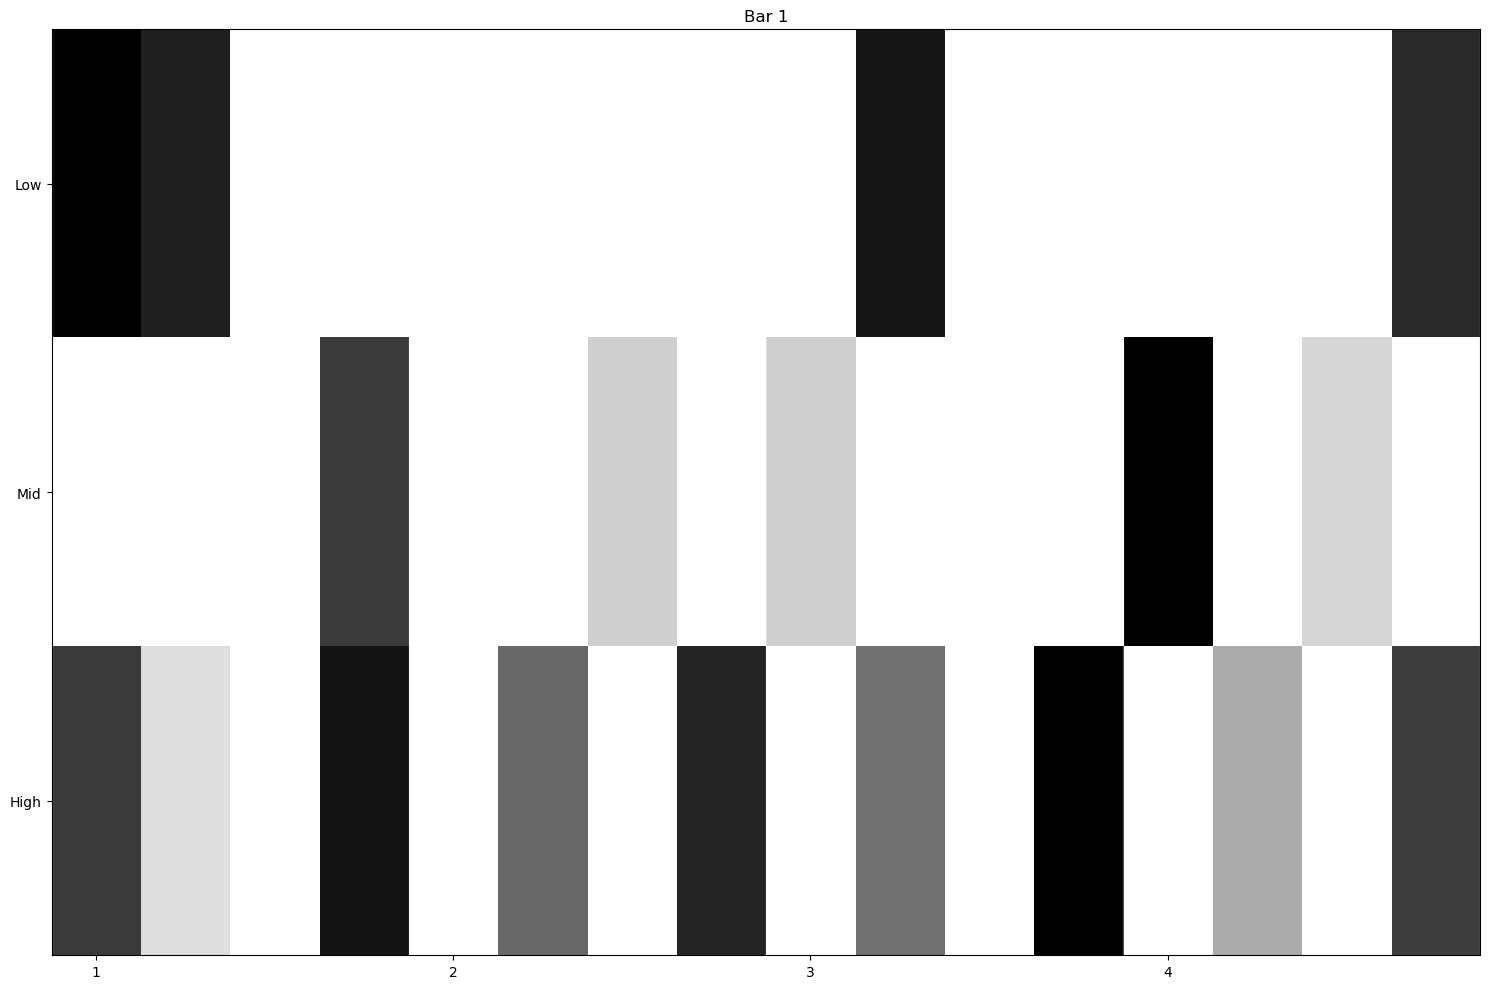

In [22]:
# Add this code to your notebook where you load and iterate through the dataset
# This would likely be after the cell where you define the dataloader

# To see which file is being processed
for i, (audio, fs, midi_reps, bpm, style) in enumerate(dataloader):
    # Extract the audio_filename from the dataset
    audio_filename = groove.data[i]['audio_filename']
    print(f"Processing file {i+1}/{len(groove)}:")
    print(f"Audio: {audio_filename}")
    print(f"BPM: {bpm.item()}")
    print(f"Style: {style[0]}")
    
    # Example: display the first bar's matrix
    if len(midi_reps) > 0:
        print(f"Number of bars: {len(midi_reps)}")
        # Example: visualize the first bar
        plot_multiband_groove([midi_reps[0]], bpm.item())
    
    # If you only want to see one example, you can break after the first iteration
    break  # Remove this line if you want to see all files

[tensor([[1.0000, 0.8906, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.9219, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8594],
        [0.0000, 0.0000, 0.0000, 0.8158, 0.0000, 0.0000, 0.2895, 0.0000, 0.2895,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.2632, 0.0000],
        [0.8156, 0.2199, 0.0000, 0.9291, 0.0000, 0.6667, 0.0000, 0.8723, 0.0000,
         0.6312, 0.0000, 1.0000, 0.0000, 0.4326, 0.0000, 0.8085]],
       dtype=torch.float64), tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.7581, 0.8710, 0.0000, 0.0000, 0.0000, 0.0000, 0.9194],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.3404, 0.2553,
         0.0000, 0.0000, 0.9468, 0.0000, 0.0000, 0.3936, 0.4362],
        [0.0000, 0.5128, 0.3504, 0.6838, 0.4359, 0.5726, 0.3846, 0.6154, 0.3675,
         0.2991, 0.3077, 0.6581, 0.4615, 0.4444, 0.3333, 1.0000]],
       dtype=torch.float64), tensor([[0.0000, 0.9394, 0.0000, 0.0000, 0.0000, 0.0000, 

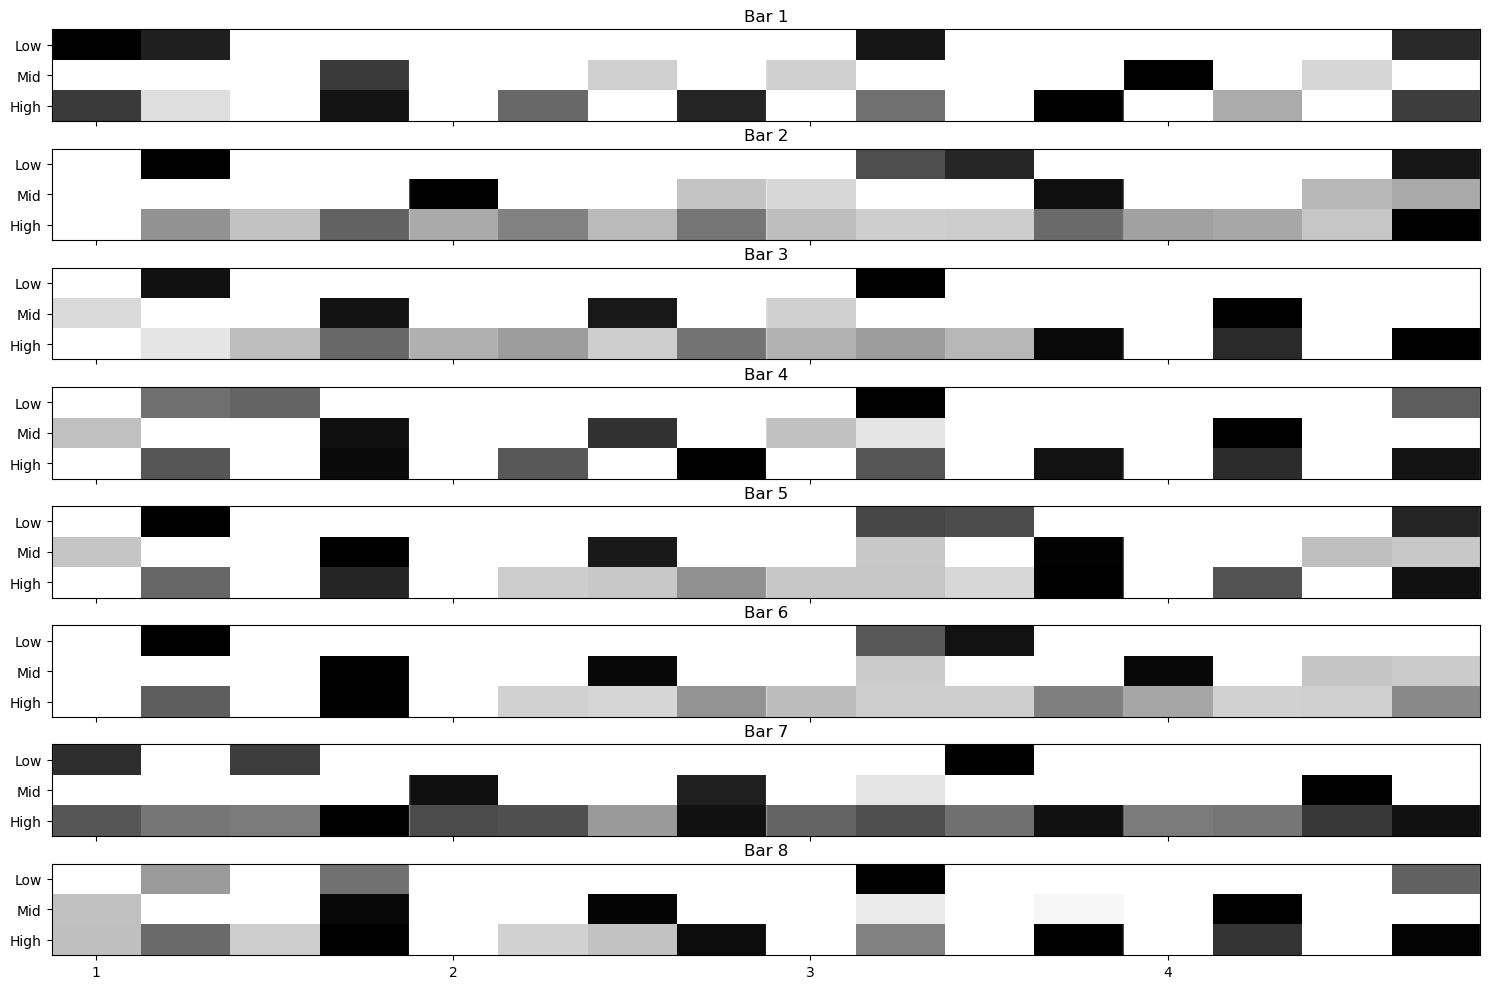

In [23]:
batch = next(iter(dataloader))
x, fs,midi_reps, bpm, style = batch


# first_bar = midi_reps[0].squeeze(0)
# print(f"Shape of first bar: {first_bar.shape}")
# print(f"First bar: {first_bar}")

# low_band = first_bar[0]
# mid_band = first_bar[1]
# high_band = first_bar[2]

# print('='*50)
# print(f"Low band: {low_band}")
# print(f"Mid band: {mid_band}")
# print(f"High band: {high_band}")
# print('='*50)

print([x.squeeze() for x in midi_reps])

# Extract the actual BPM value from the tensor if needed
if isinstance(bpm, torch.Tensor):
    bpm_value = bpm.item()
else:
    bpm_value = bpm

# Process midi_reps to ensure proper shape (remove batch dimension if needed)
processed_reps = []
for bar in midi_reps:
    if bar.dim() > 2:
        processed_reps.append(bar.squeeze(0))
    else:
        processed_reps.append(bar)

# Plot multiple bars
plot_multiband_groove(processed_reps, bpm_value, num_bars=min(8, len(processed_reps)))


# # select only the first segment
# segment_duration_seconds = 16 *  (60 / bpm / 4)
# print(f"Segment duration {segment_duration_seconds} seconds")
# segment_duration_samples = int(segment_duration_seconds * fs.item())
# sample = x[0,0,:segment_duration_samples].numpy()
# # get player
# display(Audio(sample,rate=fs.item()))
# # plot audio representations
# # plot_groove(sample, bpm, "sample", fs.item(),segment_duration_seconds)
# # plot midi rep
# plt.matshow(midi_rep[0].flatten().cpu().numpy().reshape(1,-1),aspect="auto",cmap="gray_r")
# plt.title("Midi representation");